# 全方向移動でのマルコフ決定過程の実装

In [33]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm

import math
import numpy as np
from scipy.stats import expon, norm, multivariate_normal
from matplotlib.patches import Ellipse

## Worldの作成

In [34]:
class Goal:
    def __init__(self, x, y, radius=0.3, value=0.0):
        self.pos = np.array([x, y]).T
        self.radius = radius
        self.value = value           #追加
        
    def inside(self, pose): #ゴールの範囲設定
        return self.radius > math.sqrt( (self.pos[0]-pose[0])**2 + (self.pos[1]-pose[1])**2 )
        
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.16, y + 0.5, s=50, marker=">", label="landmarks", color="red")
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 0.6], color="black")

In [35]:
class Puddle: #水たまり
    def __init__(self, lowerleft, upperright, depth):
        self.lowerleft = lowerleft
        self.upperright = upperright
        self.depth = depth
        
    def draw(self, ax, elems):
        w = self.upperright[0] - self.lowerleft[0]
        h = self.upperright[1] - self.lowerleft[1]
        r = patches.Rectangle(self.lowerleft, w, h, color="blue", alpha=self.depth)
        elems.append(ax.add_patch(r))
        
    def inside(self, pose): 
        return all([ self.lowerleft[i] < pose[i] < self.upperright[i]  for i in [0, 1] ])

In [39]:
class PuddleWorld():
    def __init__(self, time_span, time_interval, debug=False):
#         super().__init__(time_span, time_interval, debug)
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
        
        self.puddles = []
        self.robots = []
        self.goals = []
        
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-5,5)                  
        ax.set_ylim(-5,5) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
    
    def append(self,obj):
        self.objects.append(obj)
        if isinstance(obj, Puddle): self.puddles.append(obj)
#         if isinstance(obj, Robot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
        
    def puddle_depth(self, pose):
        return sum([p.depth * p.inside(pose) for p in self.puddles])
    
    def one_step(self, i, elems, ax): ###puddleworld4
#         super().one_step(i, elems, ax)
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
        for r in self.robots:
            r.agent.puddle_depth = self.puddle_depth(r.pose)
            for g in self.goals: #以下追加
                if g.inside(r.pose):
                    r.agent.in_goal = True
                    r.agent.final_value = g.value

In [40]:
class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)

## Robotの作成

<IPython.core.display.Javascript object>


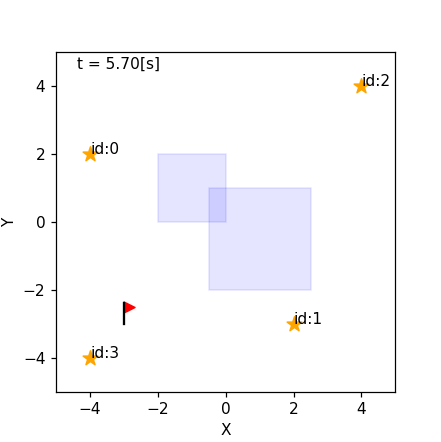

In [42]:
def trial():  ###puddle_world4_trial
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3)  #goalを変数に
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

#    ##ロボットを作る##
#     initial_pose = np.array([2, 2,0]).T
#     kf = KalmanFilter(m, initial_pose) 
#     a = PuddleIgnoreAgent(time_interval, kf, goal) #goalを渡す
#     r = Robot(initial_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
#               agent=a, color="red", bias_rate_stds=(0,0))
#     world.append(r)
    
    world.draw()
    
trial()